In [1]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl


import schemes.avalanche_scheme 
import utils.post_processing as post

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver
import models.parameterized_morph_models as parameter_models
import models.parameterized_models.parameterized_exner_models as exner_models

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

dx: 0.6505421184320267 cm
nx 1200


Text(0, 0.5, 'z (m)')

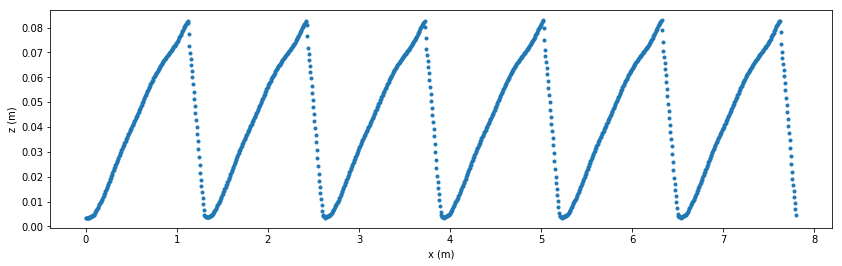

In [2]:
filepath = 'dune_profile_dune5_repeated.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [3]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.0010
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.002

#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60       # Runtime in seconds
dt = 1                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*5

## Equilibrium Conditions

In [4]:
# Load up OpenFOAM

OpenFOAMtau32 = pd.read_csv(r'tau32df.csv')
openfoam_qsb_kw = []
D50=0.001
for i in range(OpenFOAMtau32.shape[0]):
    tau = OpenFOAMtau32.tau[i]
    qsb = sedtrans.get_unit_bed_load(tau=tau, D0=D50)
    openfoam_qsb_kw.append(qsb)

0.3569942383232911
0.5921206725634764


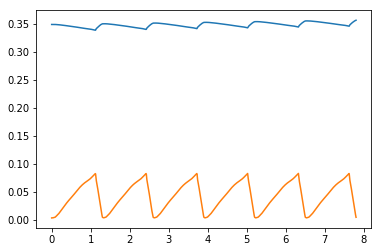

<Figure size 1008x432 with 0 Axes>

In [5]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut32, 0.0)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

h = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

In [6]:
uf = model.get_uf()
hf = model.get_hf()
tauf = []
swe_qsb = []
for i in range(len(hf)):
    tauf.append(sedtrans.get_bed_shear(hf[i], uf[i], D50))
    swe_qsb.append(sedtrans.get_unit_bed_load2(hf[i], uf[i],D50,rho_particle,type='bagnold'))


In [7]:
#---------------------------------
# Specific properties for the case
#----------------------------------
qsbmax = 0.000020375
delta = 0.079
zoffset = 0.0034

ebm = parameter_models.EquilibriumBedloadModel(qsbmax, delta, zoffset)
param_qsb = ebm.calculate_bedload(hf, uf, x0, z0, 0.1)

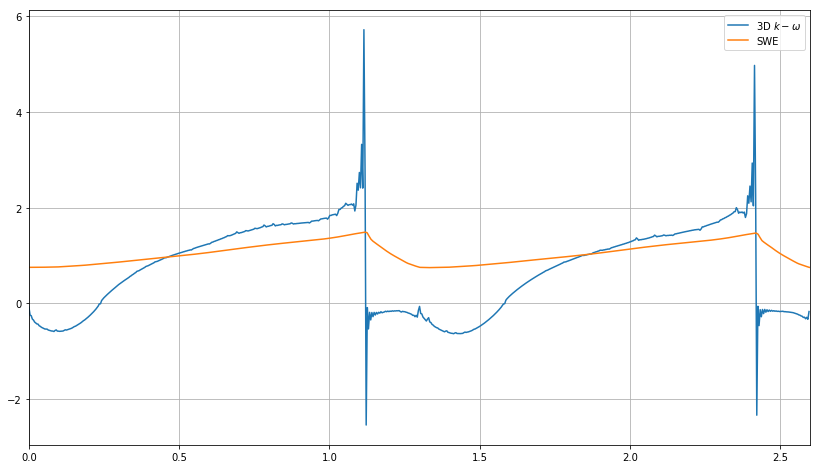

In [8]:
plt.figure(figsize=(14,8))

plt.plot(OpenFOAMtau32.x, OpenFOAMtau32.tau, label='3D $k-\omega$')
plt.plot(x0,tauf, label='SWE')
#plt.hlines(y=tau_cr,xmin=0, xmax=x.max(), color='r')

#plt.hlines(y=-1.0*tau_cr,xmin=0, xmax=x.max(), color='r')
plt.xlim([0, 2.6])
plt.legend()
plt.grid()

In [9]:
measuredQsb32 = pd.read_csv(r'qsb_measured_32.csv')

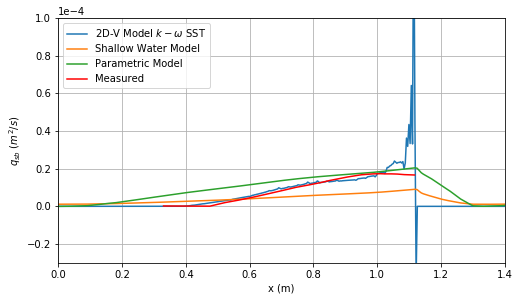

In [10]:

plt.figure(figsize=(8,4.5))

plt.plot(OpenFOAMtau32.x, openfoam_qsb_kw, label='2D-V Model $k-\omega$ SST')
plt.plot(x0,swe_qsb, label='Shallow Water Model')
plt.plot(x0,param_qsb, label='Parametric Model')

plt.plot(measuredQsb32.x-0.17, measuredQsb32.qsb/10000., 'r', label='Measured')

plt.xlim([0, 1.4])
plt.ylim([-0.00003, 0.00010])
plt.xlabel('x (m)')
plt.ylabel('$q_{sb}$ $(m^2/s)$')
plt.legend()
plt.grid()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

## Non-Equilibrium

In [11]:
openfoam_qsb_kw
# Load up OpenFOAM

OpenFOAMtau20 = pd.read_csv(r'tau20df.csv')
openfoam_qsb_kw = []
D50=0.001
for i in range(OpenFOAMtau20.shape[0]):
    tau = OpenFOAMtau20.tau[i]
    qsb = sedtrans.get_unit_bed_load(tau=tau, D0=D50)
    openfoam_qsb_kw.append(qsb)

0.3569942383232911
0.4316947741856175


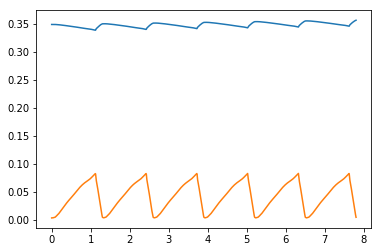

<Figure size 1008x432 with 0 Axes>

In [12]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)
#model.set_mannings_source_term(mannings=0.022, slope=1/792.)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, 0.4)
model.set_controller(tfinal = 300, num_output_times=1)
model.run()

hf = model.get_hf()
surf = h + z0

plt.plot(x0, surf)
plt.plot(x0, z0)

fig = plt.figure(figsize=(14, 6))
print(surf[len(x0)-1])
print(model.get_uf().mean())

In [13]:
uf = model.get_uf()
tauf = []
swe_qsb = []
for i in range(len(hf)):
    tauf.append(sedtrans.get_bed_shear(hf[i], uf[i], D50))
    swe_qsb.append(sedtrans.get_unit_bed_load2(hf[i], uf[i],D50,rho_particle,type='mpm'))


In [14]:
qsbmax = 0.000020375
delta = 0.079
zoffset = 0.0034
c = 1.0
d = -0.02 #0.2
qsbmodel = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
param_qsb = qsbmodel.calculate_bedload(hf, uf, x0, z0, 0.1)

Initalized


In [15]:
qsb = 'qsb_measured_20.csv'

measuredQsb20 = pd.read_csv(r'qsb_measured_20.csv')

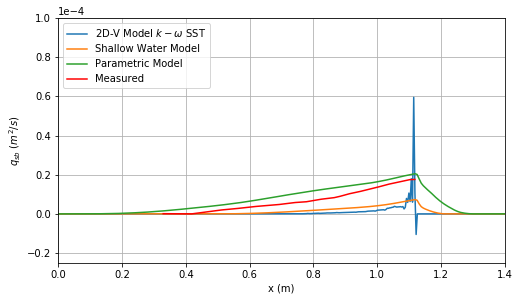

In [20]:
plt.figure(figsize=(8,4.5))

plt.plot(OpenFOAMtau20.x, openfoam_qsb_kw, label='2D-V Model $k-\omega$ SST')
plt.plot(x0,swe_qsb, label='Shallow Water Model')
plt.plot(x0,param_qsb, label='Parametric Model')

plt.plot(measuredQsb20.x-0.17, measuredQsb20.qsb/10000., 'r', label='Measured')

plt.xlim([0, 1.4])
plt.ylim([-0.000025, 0.0001])
plt.xlabel('x (m)')
plt.ylabel('$q_{sb}$ $(m^2/s)$')
plt.legend(loc='upper left')
plt.grid()

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [21]:
qsbmax = 0.000020375
delta = 0.079
zoffset = 0.0034
c = 1.0
d = -0.02 #0.2

qsbmodel_neq = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
param_neq_qsb = qsbmodel_neq.calculate_bedload(hf, uf, x0, z0, 0)

qsbmodel_eq = parameter_models.EquilibriumBedloadModel(qsbmax, delta, zoffset)
param_eq_qsb = qsbmodel_eq.calculate_bedload(hf, uf, x0, z0, 0.1)


Initalized


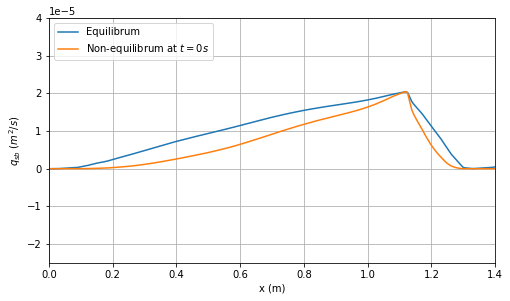

In [29]:
plt.figure(figsize=(8,4.5))

plt.plot(x0,param_eq_qsb, label='Equilibrum')
plt.plot(x0,param_neq_qsb, label='Non-equilibrum at $t=0 s$')


plt.xlim([0, 1.4])
plt.ylim([-0.000025, 0.00004])
plt.xlabel('x (m)')
plt.ylabel('$q_{sb}$ $(m^2/s)$')
plt.legend(loc='upper left')
plt.grid()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))